In [ ]:
# get the World Ocean Atlas annual T/S data
# wget in disguise in the Makefile
!make getdata

In [22]:
# we need to compile the fortran code into something python can use
!make

f2py -c -m lib_watermass lib_watermass.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "lib_watermass" sources
f2py options: []
f2py:> /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp6s8jboso/src.macosx-10.7-x86_64-3.6/lib_watermassmodule.c
creating /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp6s8jboso/src.macosx-10.7-x86_64-3.6
Reading fortran codes...
	Reading file 'lib_watermass.f90' (format:free)
Post-processing...
	Block: lib_watermass
			Block: volume_watermass_from_ts
			Block: volume_watermass_from_ts_v2
			Block: volume_watermass_from_ts_v3
Post-processing (stage 2)...
Building modules...
	Building module "lib_watermass"...
		Creating wrapper for Fortran subroutine "volume_watermass_from_ts"("volume_watermass_from_ts")...
		Constructing wrapper fun

Removing build directory /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp6s8jboso
f2py -c -m creeping_sea creeping_sea.f90
running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "creeping_sea" sources
f2py options: []
f2py:> /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp0rrpug_u/src.macosx-10.7-x86_64-3.6/creeping_seamodule.c
creating /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp0rrpug_u/src.macosx-10.7-x86_64-3.6
Reading fortran codes...
	Reading file 'creeping_sea.f90' (format:free)
Post-processing...
	Block: creeping_sea
			Block: cslf
Post-processing (stage 2)...
Building modules...
	Building module "creeping_sea"...
		Constructing wrapper function "cslf"...
		  varout = cslf(varin,spval,validmin,validmax,[nx,ny])
	Wrote C/API module "creeping_sea" to file "

Removing build directory /var/folders/j4/v7kprvpx0j3cnnsmbwxbbr300000gn/T/tmp0rrpug_u


In [24]:
import xarray as xr
import lib_watermass
import numpy as np

In [3]:
#---------------------------------------------------------------
# sample data set (use make getdata to download WOA annual data)
fnameT = 'woa13_5564_t00_01.nc'
fnameS = 'woa13_5564_s00_01.nc'

woa = xr.open_mfdataset([fnameT,fnameS],decode_times=False)

In [4]:
woa.t_an

<xarray.DataArray 't_an' (time: 1, depth: 102, lat: 180, lon: 360)>
dask.array<shape=(1, 102, 180, 360), dtype=float32, chunksize=(1, 102, 180, 360)>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 -82.5 ...
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 ...
  * depth    (depth) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * time     (time) float32 6.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean
    grid_mapping:   crs
    units:          degrees_celsius

In [5]:
#---------------------------------------------------------------
# compute metrics (dx,dy,dz) of ocean grid cells and mask
Rearth = 6378e+3
nx = woa.lon.shape[0]
ny = woa.lat.shape[0]
nz = woa.depth.shape[0]

dxflat = (2*np.pi*Rearth/360) * (woa.lon_bnds[:,1] - woa.lon_bnds[:,0])
dyflat = (2*np.pi*Rearth/360) * (woa.lat_bnds[:,1] - woa.lat_bnds[:,0])
dzcolumn = (woa.depth_bnds[:,1] - woa.depth_bnds[:,0]).values

dxflat2d, dyflat2d = np.meshgrid(dxflat,dyflat)
lon2d, lat2d = np.meshgrid(woa.lon,woa.lat)

dx = dxflat2d * np.cos(2*np.pi*lat2d/360)
dy = dyflat2d

dz = np.empty((nz,ny,nx))
for jj in np.arange(ny):
        for ji in np.arange(nx):
                dz[:,jj,ji] = dzcolumn

In [6]:
#---------------------------------------------------------------
# compute mask from missing value
mask = np.ma.array(np.ones(woa.t_an.squeeze().shape))
mask[np.isnan(woa.t_an.values.squeeze())] = 0

Populating the interactive namespace from numpy and matplotlib


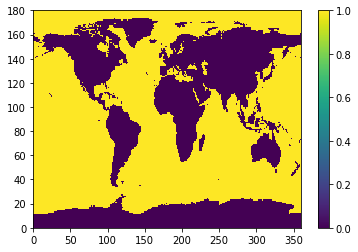

In [7]:
# Quick check on the mask
%pylab inline
import matplotlib.pylab as plt
plt.figure()
plt.pcolormesh(mask[0,:,:]) ; plt.colorbar()
plt.show()

In [8]:
#---------------------------------------------------------------
# sanity checks
# compute water volume between 50C and 55C (never observed)
wmass_testimpossible = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                              woa.t_an.transpose(),\
                                                              woa.s_an.transpose(),\
                                                              50.,55.,0.,40.)

In [9]:
# compute all possible volume
wmass_testall = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),\
                                                       woa.s_an.transpose(),\
                                                       -10.,100.,0.,50.)

# and compare to volume from metrics
wmass_from_metrics = (dx * dy * mask * dz).sum()

print('---Control checks---')
print('Impossible water mass, volume =', wmass_testimpossible)
print('All possible water, volume =', wmass_testall)
print('volume from scale factors = ', wmass_from_metrics)

---Control checks---
Impossible water mass, volume = 0.0
All possible water, volume = 1.3762046079890934e+18
volume from scale factors =  1.37620463021e+18


In [10]:
#---------------------------------------------------------------
# now let's learn some stuff
# compute volume of water 20C < T < 40C
wmass_20to40C = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),\
                                                       woa.s_an.transpose(),\
                                                       20.,40.,0.,40.)
# compute volume of water 10C < T < 20C
wmass_10to20C = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),woa.s_an.transpose(),\
                                                       10.,20.,0.,40.)
# compute volume of water 0C < T < 10C
wmass_0to10C = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                      woa.t_an.transpose(),woa.s_an.transpose(),\
                                                      0.,10.,0.,40.)

print('---Volume of ocean in temperature ranges---')
print('The percentage of ocean waters 20C < T < 40C is ', 100 * wmass_20to40C / wmass_from_metrics, '%')
print('The percentage of ocean waters 10C < T < 20C is ', 100 * wmass_10to20C / wmass_from_metrics, '%')
print('The percentage of ocean waters  0C < T < 10C is ', 100 * wmass_0to10C / wmass_from_metrics, '%')

---Volume of ocean in temperature ranges---
The percentage of ocean waters 20C < T < 40C is  1.69948501477 %
The percentage of ocean waters 10C < T < 20C is  6.10112841424 %
The percentage of ocean waters  0C < T < 10C is  88.6711761299 %


In [25]:
# note on I/O and dimensions

#---------------------------------------------------------------

wmass_20to40C = lib_watermass.volume_watermass_from_ts(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),\
                                                       woa.s_an.transpose(),\
                                                       20.,40.,0.,40.)

print('Solution from v1 is ', 100 * wmass_20to40C / wmass_from_metrics, '%')

wmass_20to40C = lib_watermass.volume_watermass_from_ts_v2(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),\
                                                       woa.s_an.transpose(),\
                                                       20.,40.,0.,40.,nx,ny,nz)


print('Solution from v2 is ', 100 * wmass_20to40C / wmass_from_metrics, '%')

wmass_20to40C = lib_watermass.volume_watermass_from_ts_v2(dx.transpose(),dy.transpose(),dz.transpose(),\
                                                       woa.t_an.transpose(),\
                                                       woa.s_an.transpose(),\
                                                       20.,40.,0.,40.)

print('Solution from v2 without nx,ny,nz is ', 100 * wmass_20to40C / wmass_from_metrics, '%')

wmass_20to40C = lib_watermass.volume_watermass_from_ts_v3(dx,dy,dz,\
                                                       woa.t_an,\
                                                       woa.s_an,\
                                                       20.,40.,0.,40.)

print('Solution from v3 without nx,ny,nz is ', 100 * wmass_20to40C / wmass_from_metrics, '%')

Solution from v1 is  1.69948501477 %
Solution from v2 is  1.69948501477 %
Solution from v2 without nx,ny,nz is  1.69948501477 %


AttributeError: module 'lib_watermass' has no attribute 'volume_watermass_from_ts_v3'